In [1]:
#MLP Imports
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras import utils

In [2]:
#CNN Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, MaxPooling1D

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import random
import time

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

num_cores = 4
GPU=True #using GPU

if GPU:
    num_GPU = 1
    num_CPU = 1
else:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})

session = tf.Session(config=config)
K.set_session(session)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5215161994090566792
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1513940582
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14147879564691002730
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [5]:
batch_size= 512 #hyperparameters
num_epochs=40
hidden_size=512


height,width,depth = 28,28,1 # mnist image size
num_classes=10 # digits 0..9

(x_train,y_train), (x_test, y_test) = mnist.load_data()

num_train = len(x_train)
num_test = len(x_test)

In [6]:
X_train=x_train.reshape(num_train, height * width) # reshape to one dimension
X_test=x_test.reshape(num_test,height*width)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train/=255 # normalisation to 0..1
X_test/=255

Y_train=utils.to_categorical(y_train,num_classes) # 4 -> [0,0,0,1,0,0,0,0,0]
Y_test=utils.to_categorical(y_test,num_classes)

In [7]:
inp=Input(shape=(height*width,)) # input layer
hidden_1=Dense(hidden_size,activation='relu')(inp)
hidden_2=Dense(hidden_size,activation='relu')(hidden_1)
hidden_3=Dense(hidden_size,activation='relu')(hidden_2)
out = Dense(num_classes,activation='softmax')(hidden_3) # 3 hidden layers

model = Model(inputs=inp, outputs=out)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [8]:
start_time = time.time()
model.fit(X_train,Y_train,
             batch_size=batch_size,
             nb_epoch=num_epochs,
             verbose=1,
             validation_split=0.1)
print("-"*15)
print("Training time: %s mins %seconds"%((time.time()-start_time)//60, (time.time()-start_time)%60))

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 12s 224us/step - loss: 0.3572 - acc: 0.9008 - val_loss: 0.1141 - val_acc: 0.9690
Epoch 2/40
54000/54000 [==============================] - 10s 180us/step - loss: 0.1084 - acc: 0.9671 - val_loss: 0.0812 - val_acc: 0.9762 loss: 0.1090 - acc: 0.
Epoch 3/40
54000/54000 [==============================] - 10s 181us/step - loss: 0.0659 - acc: 0.9799 - val_loss: 0.0748 - val_acc: 0.9782 3s - loss: 0.0679 - acc: - 
Epoch 4/40
54000/54000 [==============================] - 10s 180us/step - loss: 0.0455 - acc: 0.9860 - val_loss: 0.0788 - val_acc: 0.9758
Epoch 5/40
54000/54000 [==============================] - 10s 181us/step - loss: 0.0326 - acc: 0.9902 - val_loss: 0.0667 - val_acc: 0.9785
Epoch 6/40
54000/54000 [==============================] - 10s 182us/step - loss: 0.0240 - acc: 0.9923 - val_loss: 0.0715 - val_acc: 0.9793
Epoch 7/40
54000/54000 [==============================] - 10s 181u

In [9]:
result=model.evaluate(X_test,Y_test,verbose=1)
print("Test loss: "+str(result[0]))
print("Test Accuracy: "+str(result[1]))

10000/10000 [==============================] - 2s 243us/step
Test loss: 0.0960955237296688
Test Accuracy: 0.9802


Errors: 198 of 10000


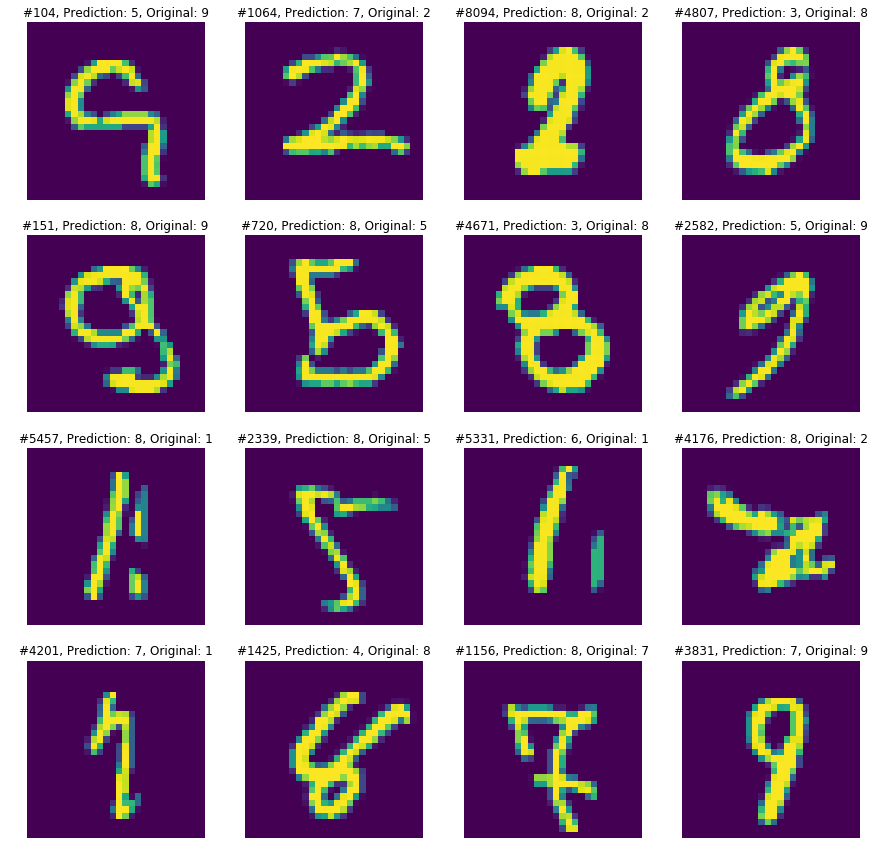

In [10]:
ans = model.predict(X_test)  
errors=[int(i) for i in range(num_test) if ans.argmax(axis=1)[i]!=y_test[i]] # get the errors from dataset
sample_size=16
samples = random.sample(errors,sample_size) # have a look at errors
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(15, 15))
for s,i in zip(samples,list(range(sample_size))):   
    axes[i%4,i//4].imshow(x_test[s])
    axes[i%4,i//4].set_title("#%d, Prediction: %d, Original: %d"%(s, ans.argmax(axis=1)[s],y_test[s]))
    axes[i%4,i//4].set_axis_off()
print ("Errors: %d of %d"%(len(errors),len(X_test)))    
plt.show()

In [11]:
#Convolutional Neural Network

In [12]:
batch_size = 128 # examples in each iteration
num_epochs = 40 # iterations
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 1024 # neurons in the FC layer
input_shape = (28,28,1) # MNIST image size

In [13]:
X_train = x_train.reshape(x_train.shape[0], height, width, 1)
X_test = x_test.reshape(x_test.shape[0], height, width, 1)
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range

Y_train = utils.to_categorical(y_train, num_classes) # 4 -> [0,0,0,1,0,0,0,0,0]
Y_test = utils.to_categorical(y_test, num_classes) 

In [14]:
model = Sequential()
model.add(Convolution2D(conv_depth_1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model.add(Convolution2D(conv_depth_2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dropout(drop_prob_2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
start_time = time.time()
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_split=0.1)
          #validation_data=(X_test, Y_test))

print("-"*15)
print("Training time: %s mins %seconds"%((time.time()-start_time)//60, (time.time()-start_time)%60))

Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 157s 3ms/step - loss: 0.2307 - acc: 0.9276 - val_loss: 0.0525 - val_acc: 0.9852
Epoch 2/40
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0509 - acc: 0.9849 - val_loss: 0.0392 - val_acc: 0.9892
Epoch 3/40
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0337 - acc: 0.9897 - val_loss: 0.0337 - val_acc: 0.9910
Epoch 4/40
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0228 - acc: 0.9928 - val_loss: 0.0358 - val_acc: 0.9918
Epoch 5/40
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0175 - acc: 0.9945 - val_loss: 0.0384 - val_acc: 0.9893
Epoch 6/40
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0137 - acc: 0.9957 - val_loss: 0.0392 - val_acc: 0.9903
Epoch 7/40
54000/54000 [==============================] - 122s 2ms/step - loss: 0.0101 - acc: 0.9963 - val_loss: 0.0395 - v

In [16]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0437569281823148
Test accuracy: 0.9928


Errors: 72 of 10000


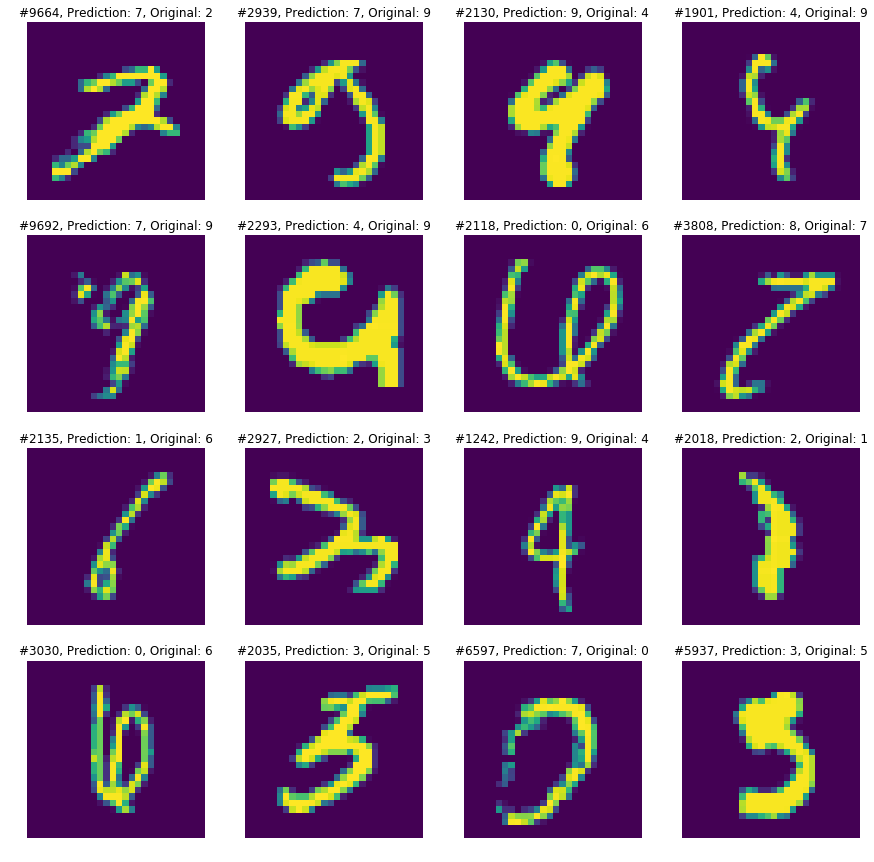

In [18]:
#Errors
ans = model.predict(X_test)
errors=[int(i) for i in range(num_test) if ans.argmax(axis=1)[i]!=y_test[i]]
sample_size=16
samples = random.sample(errors,sample_size)
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(15, 15))
for s,i in zip(samples,list(range(sample_size))):   
    axes[i%4,i//4].imshow(x_test[s])
    axes[i%4,i//4].set_title("#%d, Prediction: %d, Original: %d"%(s, ans.argmax(axis=1)[s],y_test[s]))
    axes[i%4,i//4].set_axis_off()
print ("Errors: %d of %d"%(len(errors),len(X_test)))    
plt.show()